### Image classification using TensorFlow and imagenet

Code taken from https://github.com/tensorflow/models/blob/master/tutorials/image/imagenet/classify_image.py

In [1]:
"""Simple image classification with Inception.

Run image classification with Inception trained on ImageNet 2012 Challenge data
set.

This program creates a graph from a saved GraphDef protocol buffer,
and runs inference on an input JPEG image. It outputs human readable
strings of the top 5 predictions along with their probabilities.

Change the --image_file argument to any jpg image to compute a
classification of that image.

Please see the tutorial and website for a detailed description of how
to use this script to perform image recognition.

https://tensorflow.org/tutorials/image_recognition/
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

FLAGS = None

# pylint: disable=line-too-long
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
# pylint: enable=line-too-long


class NodeLookup(object):
    """Converts integer node ID's to human readable labels."""

    def __init__(self, label_lookup_path=None, uid_lookup_path=None):
        if not label_lookup_path:
            label_lookup_path = os.path.join(FLAGS.model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
        
        if not uid_lookup_path:
            uid_lookup_path = os.path.join(FLAGS.model_dir, 'imagenet_synset_to_human_label_map.txt')
        
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        """Loads a human readable English name for each softmax node.
    
        Args:
          label_lookup_path: string UID to integer node ID.
          uid_lookup_path: string UID to human-readable string.
    
        Returns:
          dict from integer node ID to human-readable string.
        """
        if not tf.gfile.Exists(uid_lookup_path):
            tf.logging.fatal('File does not exist %s', uid_lookup_path)
        
        if not tf.gfile.Exists(label_lookup_path):
            tf.logging.fatal('File does not exist %s', label_lookup_path)

        # Loads mapping from string UID to human-readable string
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        p = re.compile(r'[n\d]*[ \S,]*')
        for line in proto_as_ascii_lines:
            parsed_items = p.findall(line)
            uid = parsed_items[0]
            human_string = parsed_items[2]
            uid_to_human[uid] = human_string

        # Loads mapping from string UID to integer node ID.
        node_id_to_uid = {}
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
                node_id_to_uid[target_class] = target_class_string[1:-2]

        # Loads the final mapping of integer node ID to human-readable string
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            if val not in uid_to_human:
                tf.logging.fatal('Failed to locate: %s', val)
            name = uid_to_human[val]
            node_id_to_name[key] = name

        return node_id_to_name

    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]


def create_graph():
    """Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile(os.path.join(
            FLAGS.model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')


def run_inference_on_image(image):
    """Runs inference on an image.
  
    Args:
      image: Image file name.
  
    Returns:
      Nothing
    """
    if not tf.gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
    image_data = tf.gfile.FastGFile(image, 'rb').read()

    with tf.Session() as sess:
        # Some useful tensors:
        # 'softmax:0': A tensor containing the normalized prediction across
        #   1000 labels.
        # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
        #   float description of the image.
        # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
        #   encoding of the image.
        # Runs the softmax tensor by feeding the image_data as input to the graph.
        softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
        predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})
        predictions = np.squeeze(predictions)

        # Creates node ID --> English string lookup.
        node_lookup = NodeLookup()

        top_k = predictions.argsort()[-FLAGS.num_top_predictions:][::-1]
        for node_id in top_k:
            human_string = node_lookup.id_to_string(node_id)
            score = predictions[node_id]
            print('%s (score = %.5f)' % (human_string, score))


def maybe_download_and_extract():
    """Download and extract model tar file."""
    dest_directory = FLAGS.model_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (
                filename, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)
    


/Users/moshfiqur/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/moshfiqur/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
parser = argparse.ArgumentParser()
# classify_image_graph_def.pb:
#   Binary representation of the GraphDef protocol buffer.
# imagenet_synset_to_human_label_map.txt:
#   Map from synset ID to a human readable string.
# imagenet_2012_challenge_label_map_proto.pbtxt:
#   Text representation of a protocol buffer mapping a label to synset ID.
parser.add_argument(
    '--model_dir',
    type=str,
    default='imagenet',
    help="""\
  Path to classify_image_graph_def.pb,
  imagenet_synset_to_human_label_map.txt, and
  imagenet_2012_challenge_label_map_proto.pbtxt.\
  """
)
parser.add_argument(
    '--image_file',
    type=str,
    default='',
    help='Absolute path to image file.'
)
parser.add_argument(
    '--num_top_predictions',
    type=int,
    default=5,
    help='Display this many predictions.'
)

FLAGS, unparsed = parser.parse_known_args()

In [3]:
maybe_download_and_extract()
image = (FLAGS.image_file if FLAGS.image_file else
         os.path.join(FLAGS.model_dir, 'cropped_panda.jpg'))

# Creates graph from saved GraphDef.
create_graph()

run_inference_on_image(image)

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca (score = 0.89107)
indri, indris, Indri indri, Indri brevicaudatus (score = 0.00779)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (score = 0.00296)
custard apple (score = 0.00147)
earthstar (score = 0.00117)


Running inference on: test_images/Screen Shot 2018-03-02 at 15.30.29.jpg


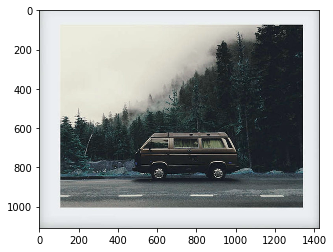

jeep, landrover (score = 0.79381)
minivan (score = 0.09003)
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon (score = 0.04981)
minibus (score = 0.00743)
recreational vehicle, RV, R.V. (score = 0.00208)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.30.37.jpg


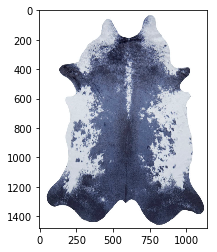

flatworm, platyhelminth (score = 0.53652)
conch (score = 0.14451)
cuirass (score = 0.01933)
sea cucumber, holothurian (score = 0.01271)
chiton, coat-of-mail shell, sea cradle, polyplacophore (score = 0.01232)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.30.48.jpg


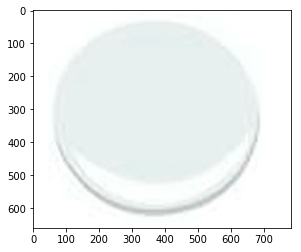

Petri dish (score = 0.55145)
loupe, jeweler's loupe (score = 0.05384)
face powder (score = 0.05043)
scale, weighing machine (score = 0.02526)
toilet seat (score = 0.01900)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.30.56.jpg


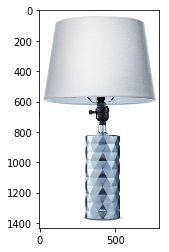

lampshade, lamp shade (score = 0.70786)
table lamp (score = 0.23033)
spotlight, spot (score = 0.00389)
car mirror (score = 0.00167)
loudspeaker, speaker, speaker unit, loudspeaker system, speaker system (score = 0.00147)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.31.03.jpg


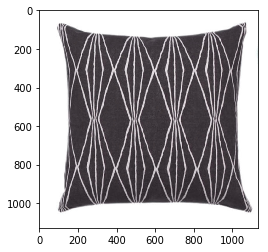

pillow (score = 0.90148)
vase (score = 0.00503)
pencil box, pencil case (score = 0.00238)
stole (score = 0.00208)
sarong (score = 0.00200)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.31.10.jpg


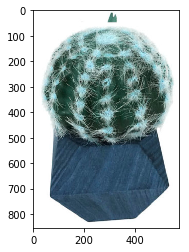

head cabbage (score = 0.57613)
tennis ball (score = 0.03368)
wool, woolen, woollen (score = 0.02568)
brain coral (score = 0.02183)
pot, flowerpot (score = 0.00976)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.31.17.jpg


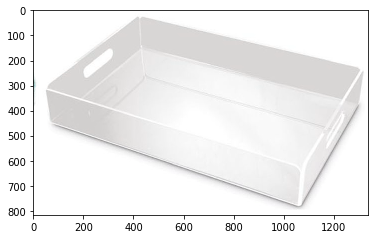

tray (score = 0.83836)
ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin (score = 0.04189)
tub, vat (score = 0.01963)
bathtub, bathing tub, bath, tub (score = 0.01521)
washbasin, handbasin, washbowl, lavabo, wash-hand basin (score = 0.00684)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.31.25.jpg


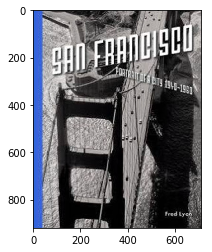

crutch (score = 0.26444)
suspension bridge (score = 0.07683)
steel arch bridge (score = 0.05277)
street sign (score = 0.04760)
cinema, movie theater, movie theatre, movie house, picture palace (score = 0.04470)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.31.30.jpg


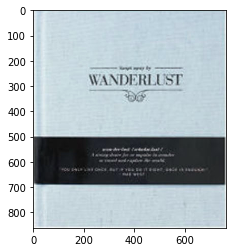

book jacket, dust cover, dust jacket, dust wrapper (score = 0.76222)
perfume, essence (score = 0.07018)
lighter, light, igniter, ignitor (score = 0.01995)
lotion (score = 0.01772)
packet (score = 0.01437)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.31.40.jpg


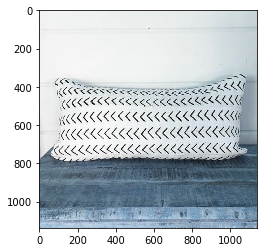

studio couch, day bed (score = 0.58871)
sombrero (score = 0.02909)
hamper (score = 0.02765)
quilt, comforter, comfort, puff (score = 0.01981)
four-poster (score = 0.01260)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.31.46.jpg


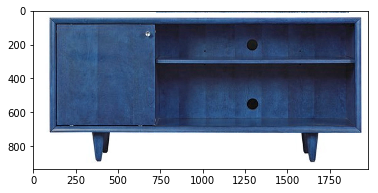

bookcase (score = 0.19605)
desk (score = 0.15131)
chiffonier, commode (score = 0.12989)
file, file cabinet, filing cabinet (score = 0.12058)
entertainment center (score = 0.03661)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.31.55.jpg


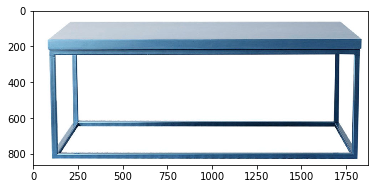

pedestal, plinth, footstall (score = 0.19377)
medicine chest, medicine cabinet (score = 0.11652)
wardrobe, closet, press (score = 0.05792)
file, file cabinet, filing cabinet (score = 0.05301)
plate rack (score = 0.04008)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.32.02.jpg


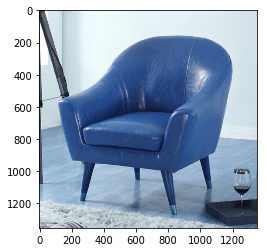

rocking chair, rocker (score = 0.20309)
velvet (score = 0.10694)
barber chair (score = 0.05568)
dining table, board (score = 0.04396)
pedestal, plinth, footstall (score = 0.04107)

Running inference on: test_images/Screen Shot 2018-03-02 at 15.32.09.jpg


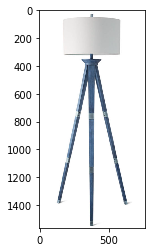

tripod (score = 0.95155)
loudspeaker, speaker, speaker unit, loudspeaker system, speaker system (score = 0.00131)
reflex camera (score = 0.00127)
spotlight, spot (score = 0.00078)
projector (score = 0.00069)



In [8]:
# Test with multiple images
from matplotlib.pyplot import imshow
from matplotlib.pyplot import show
import cv2
from time import sleep
%matplotlib inline

# Creates graph from saved GraphDef.
create_graph()

test_images = os.listdir('test_images')

for image_name in test_images:
    if '.jpg' not in image_name:
        continue
    
    image_path = os.path.join('test_images', image_name)
    print('Running inference on: ' + image_path)
    image_np = cv2.imread(image_path)
    imshow(image_np)
    show()
    run_inference_on_image(image_path)
    print()
